<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/BERT_MVP_V08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP Disciplina Machine Learning & Analytics - Modelo Deep Learning - MVP Letra b.

**b.** Modelo baseado em Deep Learning para resolver problema de Classificação de Texto e Análise de Sentimento em Processamento de Linguagem Natural (PLN).</br>
**DataSet:** Amazon Cell Phones Reviews https://www.kaggle.com/datasets/grikomsn/amazon-cell-phones-reviews. É uma base de avaliação de celulares, foi escolhida por questão didática para ilustrar um problema de classificação de texto e análise de sentimento. O dataset possui um conjunto de informações sobre as avaliações, como por exemplo: nome do avaliador, data, utilidade, body e rating. Para o escopo desse trabalho selecionamos 2 atributos do dataset: body e rating, sendo o body a avaliação do celular e o rating uma nota atribuída pelo avaliador que pode variar de 1 até 5, sendo 1 muito ruim e 5 excelente.</br>
**Qual é a descrição do problema?** É um problema de classificação de texto e análise de sentimento. Dado o texto de uma avaliação de celular precisamos determinar se a avaliação é positiva ou negativa.</br>
**Você tem premissas ou hipóteses sobre o problema? Quais?** Foi observado por amostragem que avaliações 1 e 2 são mais negativas enquanto 4 e 5 mais positivas. Vamos realizar a classificação com 5 classes para avaliação dos resultados, entretanto acredito que transformar o problema em uma classificação binária, para definir se a avaliação é positiva ou negativa deve apresentar uma melhor performance. </br>

In [2]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 45.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fo

In [3]:
import numpy as np
import pandas as pd
import pickle
import os
import gdown
import zipfile
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text
import warnings
warnings.filterwarnings("ignore")

In [4]:
CARGA_PESOS_MODELO_BIN = True
CARGA_PESOS_MODELO_MLT = True
#CARGA_PESOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1IZEbgA3kCAwLh5JfOdRgewcGibVPUTWC&export=download"
CARGA_PESOS_ZIP_URL_DRIVE = "https://drive.google.com/u/0/uc?id=1RVh7Q7_Debq_FNHi7dKssetPqfmmg3eJ&export=download"
ZIP_NAME_COLAB = 'pesos.zip'
PATH_PESOS_COLAB_FILE_BIN = '/content/bert_mvp/pesos_modelo_bin.h5'
PATH_PESOS_COLAB_FILE_MLT = '/content/bert_mvp/pesos_modelo_mlt.h5'
PATH_PESOS_COLAB_FOLDER = '/content/bert_mvp/'

In [5]:
if os.path.exists(PATH_PESOS_COLAB_FOLDER):
  shutil.rmtree(PATH_PESOS_COLAB_FOLDER)

os.makedirs(PATH_PESOS_COLAB_FOLDER, exist_ok=True) # cria a pasta de destino se necessário

In [6]:
#Download dos dados de treinamento
if CARGA_PESOS_MODELO_BIN or CARGA_PESOS_MODELO_MLT:
  zip_file = PATH_PESOS_COLAB_FOLDER + ZIP_NAME_COLAB # especifique o nome do arquivo e a extensão do mesmo
  gdown.download(CARGA_PESOS_ZIP_URL_DRIVE, zip_file)

Downloading...
From: https://drive.google.com/u/0/uc?id=1RVh7Q7_Debq_FNHi7dKssetPqfmmg3eJ&export=download
To: /content/bert_mvp/pesos.zip
100%|██████████| 811M/811M [00:11<00:00, 72.0MB/s]


In [7]:
if CARGA_PESOS_MODELO_BIN or CARGA_PESOS_MODELO_MLT:
  # Abre o arquivo ZIP
  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
      # Extrai todo o conteúdo para a pasta de destino
      zip_ref.extractall(PATH_PESOS_COLAB_FOLDER)

# Importando DataSet Amazon Cell Phones Reviews.
Vamos trabalhar com 2 instâncias do dataset, a primeira para classificação multiclasse (df_mult) e o segundo para classificação binária. O objetivo é comparar a performance das 2 abordagens.

In [8]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/20191226-reviews.csv"

# Lê o arquivo
df_mult = pd.read_csv(url, delimiter=',', encoding='latin-1')
df_bin = pd.read_csv(url, delimiter=',', encoding='latin-1')

df_bin.head(5)

,asin,name,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,Janet,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,Luke Wyatt,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,Brooke,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,amy m. teague,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,tristazbimmer,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0


# Preparação e pre-processamento dos Dados
Realizamos algumas operações para simplificação dos dados e adequação antes de submeter para  pre-processamento e treinamento.
*   Vamos trabalhar com um subconjunto de 10.000 registros
*   Para o dataset utilizado na classificação binária vamos adaptar a coluna "rating" da seguinte forma: os valores 1 e 2 vão ser transformados em "0", os valores 4 e 5 serão convertidos em "1" e o valor 3 "None".
*   Remover as linhas que contêm valores ausentes (NaN)
*   Redefinir os índices do DataFrame após a remoção das linhas com valores ausentes.
*   Remove caracteres especiais não reconhecidos, usando encode e decode entre os padrões ASCII e UTF-8
*   Seleciona somente as colunas "Body" e "Rating" que vão ser parte do escopo do trabalho.

In [9]:
# Utilize groupby para separar os registros por valor do rating
grouped_bin = df_bin.groupby('rating')
grouped_mlt = df_mult.groupby('rating')

num_samples_per_rating = 3500        # Número desejado de registros de cada valor de rating
sampled_dfs_bin = []
sampled_dfs_mlt = []

# Percorre cada grupo, fazendo o sampling de registros de cada grupo
for rating, group in grouped_bin:
    sampled_group_bin = group.sample(n=num_samples_per_rating, random_state=42)
    sampled_dfs_bin.append(sampled_group_bin)

for rating, group in grouped_mlt:
    sampled_group_mlt = group.sample(n=num_samples_per_rating, random_state=42)
    sampled_dfs_mlt.append(sampled_group_mlt)

# Concatena os DataFrames amostrados em um único DataFrame final
df_bin = pd.concat(sampled_dfs_bin)
df_mult = pd.concat(sampled_dfs_mlt)

# Embaralha os registros no DataFrame resultante
df_bin = df_bin.sample(frac=1, random_state=42)
df_mult = df_mult.sample(frac=1, random_state=42)

In [10]:
#df_mult = df_mult.head(10000)
#df_bin = df_bin.head(10000)

In [11]:
mapping={1:0,2:0,3:None,4:1,5:1}
df_bin.rating=df_bin.rating.map(mapping)
df_bin=df_bin.dropna(subset='rating')

In [12]:
df_bin.head(100)

,asin,name,rating,date,verified,title,body,helpfulVotes
14052,B00OEK6TWU,christina,0.0,"April 21, 2017",True,I'd Recommend purchasing a phone from your car...,This phone freezes. It doesn't allow me to dow...,1.0
45737,B079SQ5VHX,Michael Royer,0.0,"November 6, 2018",True,Suspected LCD problem with galaxy s9.,Quite attracted to the product first hand. Qui...,9.0
33592,B06XZRH5ZC,Guillermo Ayala Alvarenga,0.0,"November 23, 2017",True,Worst phone EVER,Worst phone EVER! the wifi setting suddendly s...,2.0
21714,B01D0JV7AO,Anonymous,0.0,"September 6, 2016",True,Take your business to a different company,Save your money and never buy from this sham o...,372.0
8981,B00F9RRVUG,CJ_NY,1.0,"September 22, 2014",True,A perfectly functional phone,A great drop phone for those times you need to...,3.0
...,...,...,...,...,...,...,...,...
11450,B00KM10ITK,Jerome Romero,0.0,"August 4, 2015",True,Two Stars,Phone doesn't work,NaN
40512,B0766TPHSH,Lord_Theoden,0.0,"March 20, 2018",True,So far the phone is fine but not being able to...,I'm only giving this a 2 star because when I g...,4.0
41906,B0775451TT,Alexander Duff,1.0,"July 31, 2019",True,good,good,NaN
33802,B06Y16RL4W,Vic,1.0,"October 14, 2019",True,Wont work with Xfinity,Great Phone But if you want to use it with wit...,NaN


In [13]:
df_bin = df_bin[["body", "rating"]]
df_mult = df_mult[["body", "rating"]]
df_mult.loc[:, "rating"] = df_mult["rating"].astype(float)

In [14]:
df_mult = df_mult.dropna()
df_mult = df_mult.reset_index(drop=True)

df_bin = df_bin.dropna()
df_bin = df_bin.reset_index(drop=True)

In [15]:
rat_bin=df_bin.rating.value_counts()
rat_mult=df_mult.rating.value_counts()

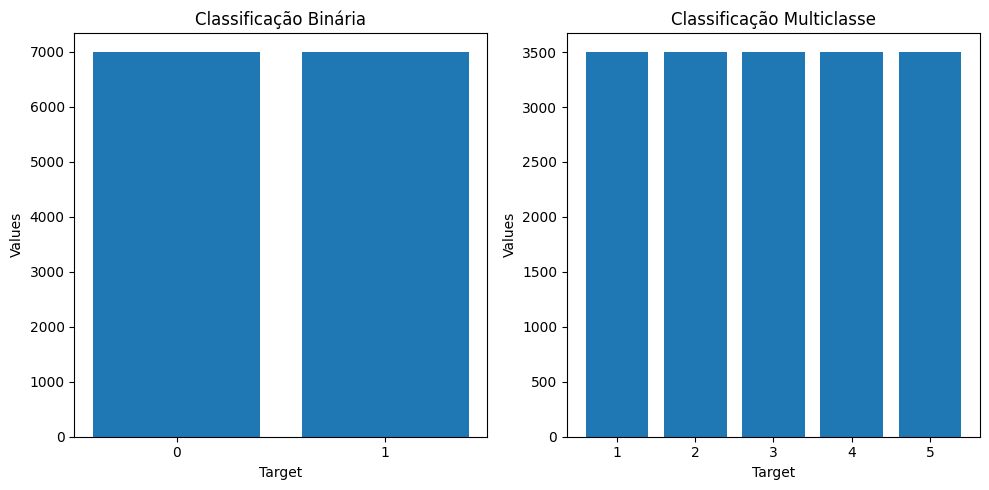

In [16]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plotagem do primeiro gráfico
axes[0].bar(rat_bin.index, rat_bin.values)
axes[0].set_xticks(rat_bin.index)
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Values')
axes[0].set_title('Classificação Binária')

# Plotagem do segundo gráfico
axes[1].bar(rat_mult.index, rat_mult.values)
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Values')
axes[1].set_title('Classificação Multiclasse')

# Ajuste de layout e exibição dos gráficos
plt.tight_layout()
plt.show()

In [17]:
df_bin.loc[:, "body"] = df_bin["body"].str.encode("ascii", "ignore").str.decode("utf-8")
df_mult.loc[:, "body"] = df_mult["body"].str.encode("ascii", "ignore").str.decode("utf-8")

In [18]:
df_mult.head(10)

,body,rating
0,This phone freezes. It doesn't allow me to dow...,1.0
1,Ive had this phone for about 8 months now and ...,3.0
2,Quite attracted to the product first hand. Qui...,2.0
3,"Although this phone looks good, there are cert...",3.0
4,Worst phone EVER! the wifi setting suddendly s...,1.0
5,Save your money and never buy from this sham o...,1.0
6,A great drop phone for those times you need to...,4.0
7,This has been the worst phone I've ever owned....,1.0
8,"I really loved this phone at first, but I only...",3.0
9,THE PHONE IS SUPPOSED TO BE UNLOCKED PHONE. UN...,2.0


# Separação em base de treino e teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df_bin.body,df_bin.rating,test_size=0.2)
R_train, R_test, t_train, t_test = train_test_split(df_mult.body,df_mult.rating,test_size=0.2)

In [20]:
R_train.head(10)

10764    I got this phone at 12/01/2016 and today is 01...
12429                                          Budget king
10726    I like the phone but I feel like its a boot le...
12471    Becomes a memory hog after few weeks of usage....
5601     I purchased this phone at BestBuy during the P...
16031                      Excellent phone! Amazing value.
8834     Phone does not work with h2o Mobile. May work ...
69       Wanted small tablet I can travel with to read,...
10492                                       Awesome phone 
1627                                    Battery don't last
Name: body, dtype: object

# Carrega o BERT preprocessor e encoder
O modelo BERT (Bidirectional Encoder Representations from Transformers) é um modelo de linguagem pré-treinado desenvolvido pelo Google que possui uma arquitetura baseada em transformers. No escopo desse trabalho o BERT foi utilizado para classificação de texto.

In [21]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [22]:
#1 neuronio de saída com ativação sigmoid
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
model_bin=tf.keras.Model(inputs=[text_input],outputs=[l])


#Alterado para considerar as 5 classses e ativação softmax
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model_mult=tf.keras.Model(inputs=[text_input],outputs=[l])

In [23]:
#model_bin.summary()

In [24]:
METRICS_BIN=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

METRICS_MULT=[
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
model_bin.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=METRICS_BIN)
#model_mult.compile(optimizer='adam',loss='categorical_crossentropy',metrics=METRICS_MULT)
#model_bin.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS_BIN)

In [25]:
if CARGA_PESOS_MODELO_BIN:
  model_bin.load_weights(PATH_PESOS_COLAB_FILE_BIN) #Carrega os pesos do modelo
  history = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'rb') as f:
    history.history = pickle.load(f)
else:
  history = model_bin.fit(X_train,y_train,epochs=10)
  model_bin.save_weights(PATH_PESOS_COLAB_FILE_BIN) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_bin.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history.history, f)

In [26]:
if CARGA_PESOS_MODELO_MLT:
  model_mult.load_weights(PATH_PESOS_COLAB_FILE_MLT) #Carrega os pesos do modelo
  history_mult = keras.callbacks.History()
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'rb') as f:
    history_mult.history = pickle.load(f)
else:
  #Converta os rótulos de classe em codificação one-hot
  t_train_adjusted = t_train - 1
  t_train_one_hot = tf.keras.utils.to_categorical(t_train_adjusted, num_classes=5)
  #Treinamento do modelo com 5 classes
  history_mult = model_mult.fit(R_train,t_train_one_hot,epochs=10)
  model_mult.save_weights(PATH_PESOS_COLAB_FILE_MLT) #Salva os pesos do modelo
  # Salvar o histórico de treinamento
  path = PATH_PESOS_COLAB_FOLDER + 'history_mlt.pkl'
  with open(path, 'wb') as f:
      pickle.dump(history_mult.history, f)

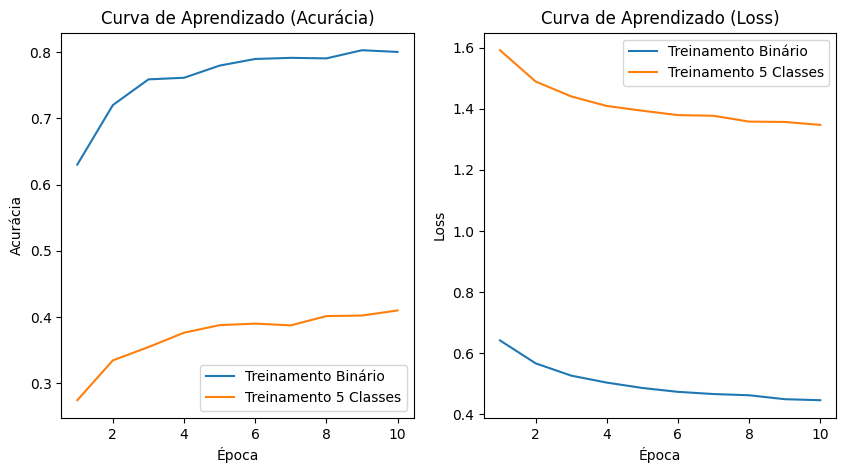

In [39]:
import matplotlib.pyplot as plt

# Criação da grade de subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Obtendo os scores de treinamento do histórico
train_scores_mult = history_mult.history['accuracy']
train_scores = history.history['accuracy']

# Obtendo os valores de Loss do histórico
train_loss = history.history['loss']
train_loss_mult = history_mult.history['loss']

# Plotando a curva de aprendizado
axes[0].plot(range(1, 11), train_scores, label='Treinamento Binário')
axes[0].plot(range(1, 11), train_scores_mult, label='Treinamento 5 Classes')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Acurácia')
axes[0].set_title('Curva de Aprendizado (Acurácia)')
axes[0].legend()


# Plotando a curva de aprendizado
axes[1].plot(range(1, 11), train_loss, label='Treinamento Binário')
axes[1].plot(range(1, 11), train_loss_mult, label='Treinamento 5 Classes')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Loss')
axes[1].set_title('Curva de Aprendizado (Loss)')
axes[1].legend()

plt.show()


In [28]:
model_bin.evaluate(X_test,y_test)

88/88 [==============================] - 30s 293ms/step - loss: 0.4326 - accuracy: 0.8096 - precision: 0.7722 - recall: 0.8673


[0.43264102935791016,
 0.8095748424530029,
 0.7722258567810059,
 0.8673469424247742]

In [29]:
#Converta os rótulos de classe em codificação one-hot
t_test_adjusted = t_test - 1
t_test_one_hot = tf.keras.utils.to_categorical(t_test_adjusted, num_classes=5)
model_mult.evaluate(R_test,t_test_one_hot)

110/110 [==============================] - 35s 306ms/step - loss: 1.3316 - accuracy: 0.3984 - precision: 0.6776 - recall: 0.0769


[1.3316128253936768,
 0.3983995318412781,
 0.6775818467140198,
 0.0768791064620018]

In [30]:
y_pred=model_bin.predict(X_test)
y_pred=y_pred.flatten()

88/88 [==============================] - 27s 306ms/step


In [31]:
t_pred=model_mult.predict(R_test)
t_pred_classes = np.argmax(t_pred, axis=1)
print(t_pred_classes)

110/110 [==============================] - 35s 312ms/step
[2 2 2 ... 4 3 0]


In [32]:
# Imprime os valores únicos somente para certificar o domínio
t_test = t_test -1
array = t_test.values
unique_values = np.unique(array)
print(unique_values)

[0. 1. 2. 3. 4.]


In [33]:
# Imprime os valores únicos somente para certificar o domínio
unique_values = np.unique(t_pred_classes)
print(unique_values)

[0 1 2 3 4]


In [34]:
y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([0, 1, 1, ..., 0, 1, 1])

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

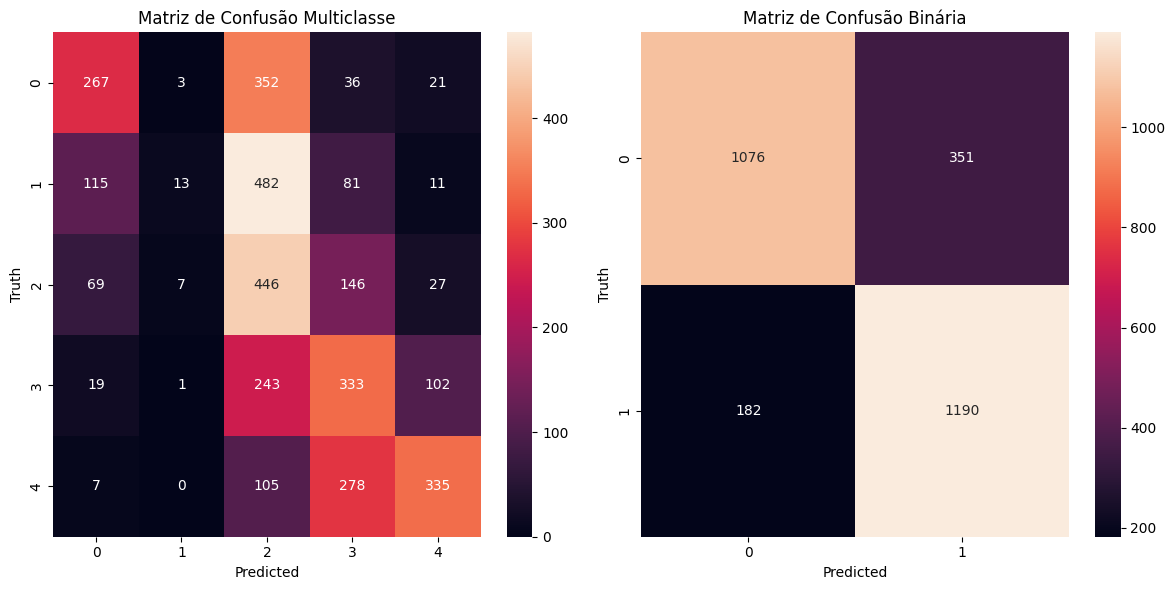

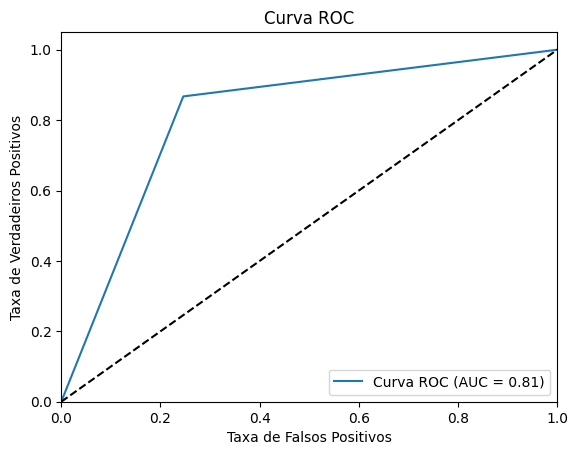

Área sob a curva (AUC): 0.8106881855755617


In [36]:
cm=confusion_matrix(y_test,y_pred)
cm_mult=confusion_matrix(t_test,t_pred_classes)

# Criação da figura e dos dois subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotagem da primeira matriz de confusão no primeiro subplot
sns.heatmap(cm_mult, annot=True, fmt='d', ax=axs[0])
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("Truth")
axs[0].set_title("Matriz de Confusão Multiclasse")

# Plotagem da segunda matriz de confusão no segundo subplot
sns.heatmap(cm, annot=True, fmt='d', ax=axs[1])
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Truth")
axs[1].set_title("Matriz de Confusão Binária")

# Ajuste do layout para evitar sobreposição de rótulos e títulos
plt.tight_layout()

# Mostrar a figura com os subplots lado a lado
plt.show()

print("\n\n")  # Espaçamento (pular linha)

fpr, tpr, thresholds = roc_curve(y_test,y_pred)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Imprimir o valor da AUC
print('Área sob a curva (AUC):', roc_auc)

In [37]:
print(classification_report(t_test,t_pred_classes,zero_division=1))

              precision    recall  f1-score   support

         0.0       0.56      0.39      0.46       679
         1.0       0.54      0.02      0.04       702
         2.0       0.27      0.64      0.38       695
         3.0       0.38      0.48      0.42       698
         4.0       0.68      0.46      0.55       725

    accuracy                           0.40      3499
   macro avg       0.49      0.40      0.37      3499
weighted avg       0.49      0.40      0.37      3499



In [38]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80      1427
         1.0       0.77      0.87      0.82      1372

    accuracy                           0.81      2799
   macro avg       0.81      0.81      0.81      2799
weighted avg       0.81      0.81      0.81      2799

